# Longformer Model for PII detection

# Installing required libararies

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 12.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=ac6f431e1a13ec4c4de54b223b1c6272e4f254cdf2be438534f027509fca1bb9
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

# Import required libraries

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
# Workflow essentials
import gc
import json
import torch
import random
import argparse
from itertools import chain
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, features, DatasetDict

# Data preprocessing and visualization
import numpy as np
import pandas as pd

# Model development
from sklearn.metrics import f1_score
from transformers import AutoModel, AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification

# Define configuration class

In [3]:
class CFG:
    # Paths to datasets
    comp_data = '/content/train.json'
    ext_data = '/content/mixtral-8x7b-v1.json'
    ext_data2 = '/content/PII_Detect_GPT3.5_Generated_data_v1.json'
    # Model paths for loading and saving
    # checkpoint = 'distilbert/distilbert-base-uncased'
    # output_name = 'distilbert'
    # output_dir = 'output'

    # Data preprocessing
    downsample = 0.29
    max_len = 2048
    workers = 4

    # Model params
    learning_rate = 5e-5
    weight_decay = 0.01
    warmup_ratio = 0.1
    batch_size = 4
    grad_steps = 2
    log_steps = 10
    epochs = 2

    # Global seed
    seed = 457

In [4]:
def global_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [5]:
# Set seed for reproducibility across multiple libraries
global_seed(CFG.seed)

In [6]:
gc.collect()

23

# Data Preprocessing steps(merging and undersampling)

In [7]:
class DataPreprocessor:
    def load_clean_concat_data(self, path1, path2, path3, downsample, max_length, seed):
        # Load JSON data as pandas DataFrames
        df1 = pd.read_json(path1)
        df2 = pd.read_json(path2)
        df3 = pd.read_json(path3)

        # Concatenate both DataFrames
        concat_df1 = pd.concat([df1, df2], ignore_index=True)
        concat_df = pd.concat([concat_df1, df3], ignore_index=True)

        # Display the shape of the DataFrame before filtering
        print(f"Shape of DataFrame before filtering: {concat_df.shape}")

        # Identify rows with positive PII labels
        concat_df['has_positive_PII'] = concat_df['labels'].apply(lambda x: any(label.startswith('B-') or label.startswith('I-') for label in x))

        # Downsample rows without positive PII labels
        df_without_positive_PII = concat_df[~concat_df['has_positive_PII']].sample(frac=downsample, random_state=seed)

        # Concatenate rows with positive PII labels and downsampled rows without positive PII labels
        concat_df = pd.concat([concat_df[concat_df['has_positive_PII']], df_without_positive_PII])

        # Drop the auxiliary column used for filtering
        concat_df.drop(columns=['has_positive_PII'], inplace=True)

        # Display the shape of the DataFrame after filtering
        print(f"Shape of DataFrame after filtering: {concat_df.shape}")
        display(concat_df.head())

        # Count essays with lengths smaller and longer than max_length
        smaller_than_max_len = concat_df[concat_df['tokens'].apply(len) <= max_length]['tokens'].count()
        longer_than_max_len = concat_df[concat_df['tokens'].apply(len) > max_length]['tokens'].count()

        # Calculate the percentage of essays with length longer than max_length
        total_essays = concat_df['tokens'].count()
        percentage_longer_than_max = (longer_than_max_len / total_essays) * 100

        # Create a DataFrame to display counts
        counts_df = pd.DataFrame({
            'Token Length': [f'Shorter than {max_length}', f'Longer than {max_length}'],
            'Count': [smaller_than_max_len, longer_than_max_len]
        })

        # Display counts
        display(counts_df)

        # Print the percentage of essays with length longer than max_length
        print(f"Percentage of essays longer than {max_length} tokens: {percentage_longer_than_max:.2f}%")

        # Convert DataFrame back to JSON format
#         json_data = concat_df.to_json(orient='records')

#         # Convert JSON data back to list of dictionaries
#         data = json.loads(json_data)

        # Return data
        return concat_df

    def tokenize(self, example, tokenizer, label2id, max_length):
        # Initialize empty lists to store tokens and corresponding labels
        text, labels = [], []

        # Iterate over each token, label, and whitespace indicator in the example
        for token, label, whitespace in zip(example["tokens"], example["provided_labels"], example["trailing_whitespace"]):
            text.append(token)
            labels.extend([label] * len(token))  # Extend labels for each token

            # Append whitespace if present after the token
            if whitespace:
                text.append(" ")
                labels.append("O")  # Add 'O' label for whitespace

        # Reconstruct the text from tokens
        text = "".join(text)

        # Tokenize the text
        tokenized = tokenizer(text,
                              return_offsets_mapping=True,
                              truncation=True,
                              max_length=max_length)

        # Initialize list to store labels assigned to each token
        token_labels = []

        # Iterate over token offset mappings
        for start_idx, end_idx in tokenized.offset_mapping:
            # Handle special case of CLS token
            if start_idx == 0 and end_idx == 0:
                token_labels.append(label2id["O"])
                continue

            # Adjust start index if token starts with whitespace
            if text[start_idx].isspace():
                start_idx += 1

            # Assign label ID to token based on start index
            token_labels.append(label2id[labels[start_idx]])

        # Calculate length of tokenized input sequence
        length = len(tokenized.input_ids)

        # Construct tokenized data dictionary
        tokenized_data = {
            "input_ids": tokenized.input_ids,
            "attention_mask": tokenized.attention_mask,
            "labels": token_labels,
            "length": length
        }

        return tokenized_data

# Initialize the DataPreprocessor
dp = DataPreprocessor()

# sample data - sequence length = 2048 for tokenizer and model

In [8]:
data = dp.load_clean_concat_data(CFG.comp_data, CFG.ext_data, CFG.ext_data2, CFG.downsample, CFG.max_len, CFG.seed)

Shape of DataFrame before filtering: (17443, 5)
Shape of DataFrame after filtering: (8538, 5)


,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


,Token Length,Count
0,Shorter than 2048,8524
1,Longer than 2048,14


Percentage of essays longer than 2048 tokens: 0.16%


# Basic EDA

In [9]:
data["labels"].explode().value_counts()

labels
O                   5942699
I-STREET_ADDRESS      19454
I-NAME_STUDENT        10628
B-NAME_STUDENT         9674
I-PHONE_NUM            8001
B-URL_PERSONAL         3509
B-EMAIL                2536
B-ID_NUM               2532
B-PHONE_NUM            2398
B-USERNAME             2390
B-STREET_ADDRESS       2298
I-ID_NUM               1061
I-URL_PERSONAL           23
Name: count, dtype: int64

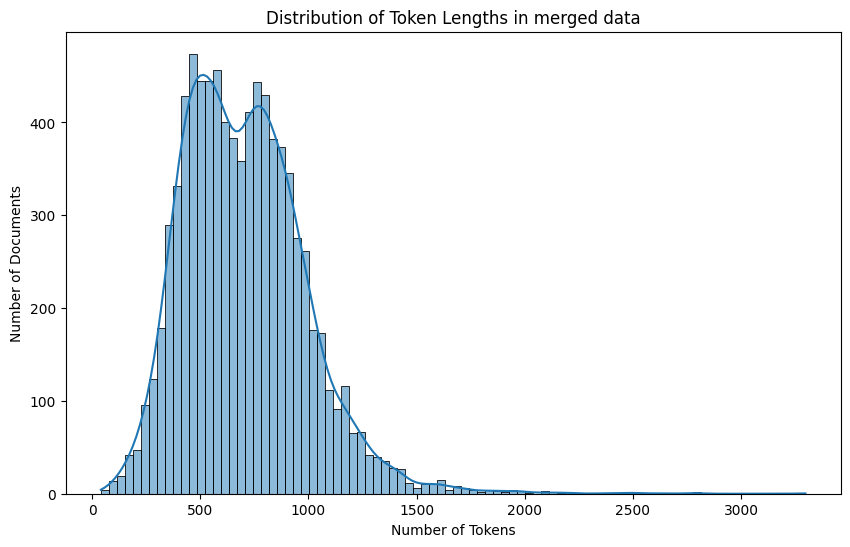

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(data["tokens"].apply(len), kde=True)
plt.title("Distribution of Token Lengths in merged data")
plt.xlabel('Number of Tokens')
plt.ylabel('Number of Documents')
plt.show()

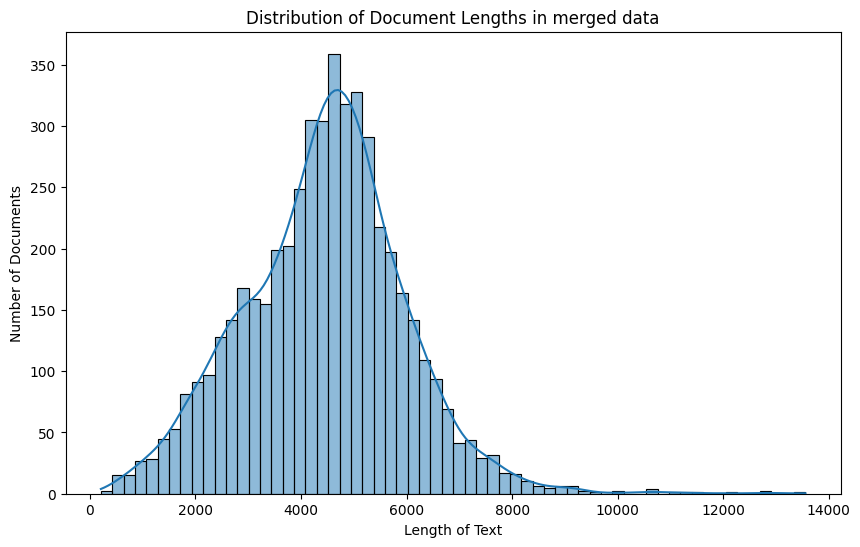

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data["full_text"].str.len(), kde=True)
plt.title("Distribution of Document Lengths in merged data")
plt.xlabel('Length of Text')
plt.ylabel('Number of Documents')
plt.show()

In [12]:
# creating configuration class for constants used throughout project
class CFG_new:
    labels = ['O','B-NAME_STUDENT','I-NAME_STUDENT','B-EMAIL','I-EMAIL','B-USERNAME',
              'I-USERNAME','B-ID_NUM','I-ID_NUM','B-PHONE_NUM', 'I-PHONE_NUM','B-URL_PERSONAL','I-URL_PERSONAL','B-STREET_ADDRESS','I-STREET_ADDRESS']
    id2label = {id : label for id, label in enumerate(labels)}
    label2id = {id : label for label, id in id2label.items()}
    # model_name = "distilbert-base-uncased"#"microsoft/deberta-v3-base"
    num_labels = len(labels)
    max_len = 2048

# Encoding the labels

In [13]:
# encoding all labels as int values
def lab2id(row):
    return [
        CFG_new.label2id[t] for t in row
    ]
data['lab_id'] = data['labels'].apply(lab2id)
data.head()

,document,full_text,tokens,trailing_whitespace,labels,lab_id
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, ..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O...","[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O...","[0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT...","[0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, ..."


In [14]:
data.shape

(8538, 6)

# Splitting data into train:valid:test in the ratio 70:15:15

In [15]:
#splitting data into testing and training
from sklearn.model_selection import train_test_split

X_train_inter, X_test = train_test_split(data, test_size=0.15, random_state=42)
X_train, X_valid = train_test_split(X_train_inter, test_size=0.175, random_state=42)
print(len(X_train), len(X_valid), len(X_test))

5987 1270 1281


In [41]:
# converting pandas datafram to torch dataset
def convert_to_dataset(data):
    return Dataset.from_dict({
        #'full_text' : [t for t in data['full_text']],
        'tokens'    : [t for t in data['tokens']],
        'labels'    : [t for t in data['labels']],
        'lab_id'    : [t for t in data['lab_id']]
    })

train = convert_to_dataset(X_train)
valid = convert_to_dataset(X_valid)
test = convert_to_dataset(X_test)

# appending both datasets into one giant one
datasets = DatasetDict({
    'train' : train,
    'validation' : valid,
    'test' : test
})

# Defining Longformer tokenizer and model from huggingface

In [4]:
from transformers import LongformerTokenizerFast, LongformerForTokenClassification

tokenizer = LongformerTokenizerFast.from_pretrained("allenai/longformer-base-4096", add_prefix_space=True)
tokenizer

LongformerTokenizerFast(name_or_path='allenai/longformer-base-4096', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [31]:
model = LongformerForTokenClassification.from_pretrained(
    "allenai/longformer-base-4096",
    num_labels=CFG_new.num_labels,
    id2label = CFG_new.id2label,
    label2id = CFG_new.label2id
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of LongformerForTokenClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# tokenizing and aligning labels

In [43]:
def align_labels(labs, wids):
    new_labs = []
    current_word = None
    for wid in wids:
        if wid != current_word:
            current_word = wid
            label = -100 if wid is None else labs[wid]
            new_labs.append(label)
        elif wid is None:
            new_labs.append(-100)
        else:
            label = labs[wid]
            new_labs.append(label)
    return new_labs

# turn labels into tokens and align them
# torch tokenizer will count seperators and beginning of sentences as tokens
# we want to ignore these when it comes to evaluating the model
def tokenize_and_align_labels(row):
    tokenized = tokenizer(
        row["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=CFG.max_len
    )
    all_labs = row["lab_id"]
    new_labs = []
    for i, labs in enumerate(all_labs):
        word_ids = tokenized.word_ids(i)
        new_labs.append(align_labels(labs, word_ids))

    tokenized['labels'] = new_labs
    return tokenized

In [44]:
# mapping previous 2 functions to our dataset
tokeized_dataset = datasets.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/5987 [00:00<?, ? examples/s]

Map:   0%|          | 0/1270 [00:00<?, ? examples/s]

Map:   0%|          | 0/1281 [00:00<?, ? examples/s]

# Defining metrics(precision, recall and f-beta) for model evaluation and hyperparameter tuning

In [45]:
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report

# function to score model as it trains
def compute_metrics(eval_prediction):
    predictions, labels = eval_prediction
    predictions = np.argmax(predictions, axis=2)

    true_preds = [
        [CFG_new.labels[p] for (p, l) in zip(prediction, label) if l != -100 and l != 0]
        for prediction, label in zip(predictions, labels)
    ]
    true_labs = [
        [CFG_new.labels[l] for (p, l) in zip(prediction, label) if l != -100 and l != 0]
        for prediction, label in zip(predictions, labels)
    ]
    precision = precision_score(true_labs, true_preds)
    recall = recall_score(true_labs, true_preds)

    return {
        "precision"             : precision,
        'recall'                : recall,
        "f1"                    : (1 + 5*5) * recall * precision / (precision + 5*5*recall)
        #'classification_report' : classification_report(true_labs, true_preds)
    }

# Defining the trainer and its arguments, loss is crossentropy as it is a multiclass classification problem

In [46]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss(ignore_index=-100)

from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, padding=True, max_length=2048, return_tensors='pt')

from transformers import Trainer, TrainingArguments

# use custom trainer to apply custom loss function and save best model
class CustomTrainer(Trainer):
    def __init__(self, model_path="./best_model", min_epochs_before_saving=5, enable_saving=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.model_path = model_path
        self.min_epochs_before_saving = min_epochs_before_saving
        self.enable_saving = enable_saving
        self.best_loss = float('inf')
        self.current_epoch = 0

    def evaluate(self, eval_dataset=None, ignore_keys=None, metric_key_prefix: str = "eval"):
        output = super().evaluate(eval_dataset, ignore_keys, metric_key_prefix)
        eval_loss = output.get("eval_loss")

        if self.enable_saving and self.current_epoch >= self.min_epochs_before_saving:
            if eval_loss < self.best_loss:
                self.best_loss = eval_loss
                print(f"Epoch {self.current_epoch}: New best model found with loss {eval_loss}. Saving to {self.model_path}")
                self.model.save_pretrained(self.model_path)
                self.tokenizer.save_pretrained(self.model_path)
            else:
                print(f"Epoch {self.current_epoch}: No improvement in eval loss.")
        else:
            print(f"Epoch {self.current_epoch}: Model saving is disabled or minimum epoch threshold not reached.")

        self.current_epoch += 1

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fn(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fn(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Define the training arguments

import os
os.makedirs('./results', exist_ok=True)
os.makedirs('./logs', exist_ok=True)

training_args = TrainingArguments(
    output_dir='./results',  # Models and outputs will be saved here
    logging_dir='./logs',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy='epoch',
    learning_rate=5e-5,
    lr_scheduler_type='cosine_with_restarts',
    load_best_model_at_end=False,
    fp16=True,
    weight_decay=0.001,
    report_to='none'
)

# Create a Custom Trainer instance to apply the loss function
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokeized_dataset['train'],
    eval_dataset=tokeized_dataset['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    model_path="./best_model",
    min_epochs_before_saving=5,
    compute_metrics=compute_metrics,
    enable_saving=True
)

# Model training

In [46]:
# Train the model
trainer.train()

Input ids are automatically padded from 937 to 1024 to be a multiple of `config.attention_window`: 512


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.019800,0.003102,0.996447,0.981722,0.995873
2,0.002200,0.002381,0.996852,0.985173,0.996398
3,0.001500,0.002374,0.997847,0.991396,0.997597
4,0.000800,0.002031,0.998237,0.990958,0.997955
5,0.000400,0.002225,0.998532,0.991736,0.998269


Input ids are automatically padded from 923 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 738 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1743 to 2048 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1211 to 1536 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1550 to 2048 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 959 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1039 to 1536 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1823 to 2048 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1350 to 1536 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 788 to 1024 to be a multipl

Epoch 0: Model saving is disabled or minimum epoch threshold not reached.


Input ids are automatically padded from 790 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 769 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 773 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 882 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 536 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1159 to 1536 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 542 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 766 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 795 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 782 to 1024 to be a multiple of 

Epoch 1: Model saving is disabled or minimum epoch threshold not reached.


Input ids are automatically padded from 745 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 742 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 501 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 845 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 573 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 489 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 534 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 681 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 702 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 645 to 1024 to be a multiple of `co

Epoch 2: Model saving is disabled or minimum epoch threshold not reached.


Input ids are automatically padded from 497 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 584 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 511 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 549 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 610 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 530 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 771 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 606 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 596 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 644 to 1024 to be a multiple of `co

Epoch 3: Model saving is disabled or minimum epoch threshold not reached.


Input ids are automatically padded from 454 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 474 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 482 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 647 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 624 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 562 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 694 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 687 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 617 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 867 to 1024 to be a multiple of `con

Epoch 4: Model saving is disabled or minimum epoch threshold not reached.


TrainOutput(global_step=7485, training_loss=0.004948512394585925, metrics={'train_runtime': 8918.462, 'train_samples_per_second': 3.357, 'train_steps_per_second': 0.839, 'total_flos': 2.110754994908706e+16, 'train_loss': 0.004948512394585925, 'epoch': 5.0})

# Plot of train and validation losses

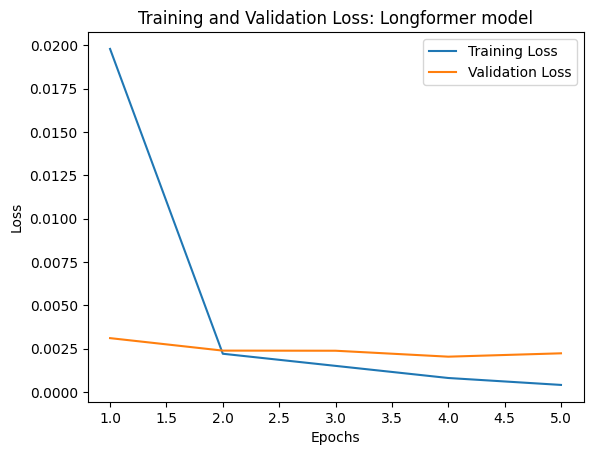

In [57]:
import matplotlib.pyplot as plt

train_loss = [0.019800, 0.002200, 0.001500, 0.000800, 0.000400]
valid_loss = [0.003102, 0.002381, 0.002374, 0.002031, 0.002225]

epochs = list(range(1,6))

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, valid_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss: Longformer model')
plt.legend()
plt.show()


# saving best model

In [47]:
trainer.save_model('best_longform_model.pth')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# eval on test
model_path = '/content/best_longform_model.pth'

# load the saved model and tokenizer
loaded_tokenizer = LongformerTokenizerFast.from_pretrained(model_path)
loaded_model = LongformerForTokenClassification.from_pretrained(model_path).to(device)
data_collator = DataCollatorForTokenClassification(tokenizer=loaded_tokenizer, padding=True, max_length=2048, return_tensors='pt')

# Create a Trainer instance
loaded_trainer = CustomTrainer(
    model=loaded_model,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator,
    enable_saving=False
)


# Evaluation on test data

In [55]:
def get_predictions(trainer, eval_dataset):
    predictions = trainer.predict(eval_dataset)
    y_pred = predictions.predictions.argmax(-1)
    y_true = predictions.label_ids
    valid_indices = y_true != -100
    y_pred = y_pred[valid_indices]
    y_true = y_true[valid_indices]
    return y_pred, y_true

y_pred, y_true = get_predictions(loaded_trainer, tokeized_dataset['test'])

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_true.flatten(), y_pred.flatten()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    962337
           1       0.97      0.99      0.98      2507
           2       0.99      0.99      0.99      2731
           3       1.00      1.00      1.00      3779
           5       1.00      1.00      1.00      1466
           7       0.99      1.00      0.99      2226
           8       1.00      1.00      1.00       583
           9       0.99      1.00      0.99      1046
          10       1.00      1.00      1.00      2348
          11       0.99      0.99      0.99      8115
          13       1.00      1.00      1.00       673
          14       1.00      1.00      1.00      4417

    accuracy                           1.00    992228
   macro avg       0.99      1.00      1.00    992228
weighted avg       1.00      1.00      1.00    992228



# Evaluation on test data given in the competition

In [4]:
test_path = '/content/test.json'
test_data = pd.read_json(test_path)
test_data

,document,full_text,tokens,trailing_whitespace
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal..."
5,86,Cheese Startup - Learning Launch ​by Eladio Am...,"[Cheese, Startup, -, Learning, Launch, ​by, El...","[True, True, True, True, True, True, True, Fal..."
6,93,Silvia Villalobos\n\nChallenge:\n\nThere is a ...,"[Silvia, Villalobos, \n\n, Challenge, :, \n\n,...","[True, False, False, False, False, False, True..."
7,104,Storytelling The Path to Innovation\n\nDr Sak...,"[Storytelling, , The, Path, to, Innovation, \...","[True, False, True, True, True, False, False, ..."
8,112,Reflection – Learning Launch\n\nFrancisco Ferr...,"[Reflection, –, Learning, Launch, \n\n, Franci...","[True, True, True, False, False, True, False, ..."
9,123,Gandhi Institute of Technology and Management ...,"[Gandhi, Institute, of, Technology, and, Manag...","[True, True, True, True, True, True, False, Tr..."


In [6]:
test_data = pd.read_json('/content/test.json')

# converting pandas datafram to torch dataset
def convert_to_testdataset(data):
    return Dataset.from_dict({
        'full_text' : [t for t in data['full_text']],
        'tokens'    : [t for t in data['tokens']]
    })

test_given = convert_to_testdataset(test_data)

In [7]:
# appending both datasets into one giant one
test_dataset = DatasetDict({
    'test' : test_given
})

In [8]:

# turn labels into tokens and align them
# torch tokenizer will count seperators and beginning of sentences as tokens
# we want to ignore these when it comes to evaluating the model
def tokenize_testdata(row):
    tokenized = tokenizer(
        row["tokens"],
        truncation=True,
        is_split_into_words=True,
        max_length=CFG.max_len
    )

    return tokenized

In [9]:
# mapping previous 2 functions to our dataset
tokeized_test_dataset = test_dataset.map(tokenize_testdata, batched=True)

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [10]:
def add_to_pred_dict(dic, i, d, tok, l, ls):
    dic['row_id'].append(i)
    dic['document'].append(d)
    dic['token'].append(tok)
    dic['label'].append(l)
    dic['tk_string'].append(ls)
    return dic

In [17]:
pred_df = {
    'row_id': [],
    'document': [],
    'token': [],
    'label': [],
    'tk_string' : [],
}

i = 0
for idx, row in test_data.iterrows():
    text = row['tokens']
    tokenized_text = loaded_tokenizer(
        text,
        truncation=False,
        max_length=None,
        is_split_into_words=True
    )
    token_map = tokenized_text.tokens()
    wids = tokenized_text.word_ids()
    input_ids = torch.tensor(tokenized_text['input_ids']).to(loaded_model.device)

    with torch.no_grad():
        log_pred = loaded_model(input_ids.unsqueeze(0)).logits
    preds = torch.argmax(log_pred, dim=2)
    ptc = [loaded_model.config.id2label[t.item()] for t in preds[0]]
    prev_word_id = -1 # num to track duplicates in data
    for w, wi in zip(ptc, wids):
        if wi is not None and w != 'O':
            if wi == prev_word_id:
                prev_word_id = wi
                continue
            pred_df = add_to_pred_dict(pred_df, i, row['document'], wi, w, text[wi])
            prev_word_id = wi
            i += 1

Input ids are automatically padded from 834 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 595 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 792 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1166 to 1536 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 2045 to 2048 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 483 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 247 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 599 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 592 to 1024 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 2154 to 2560 to be a multiple of 

#Sample predicted labels on test data

In [18]:
submission_df = pd.DataFrame(pred_df)
print(submission_df.shape)
submission_df.head(10)

(27, 5)


,row_id,document,token,label,tk_string
0,0,7,9,B-NAME_STUDENT,Nathalie
1,1,7,10,I-NAME_STUDENT,Sylla
2,2,7,482,B-NAME_STUDENT,Nathalie
3,3,7,483,I-NAME_STUDENT,Sylla
4,4,7,741,B-NAME_STUDENT,Nathalie
5,5,7,742,I-NAME_STUDENT,Sylla
6,6,10,0,B-NAME_STUDENT,Diego
7,7,10,1,I-NAME_STUDENT,Estrada
8,8,10,464,B-NAME_STUDENT,Diego
9,9,10,465,I-NAME_STUDENT,Estrada


# Lets apply the model on the train data

In [24]:
# function to predict all labels into a dictionary
# doing this to keep track of index and label for evaluating
def predict_all_labels(model, tokenizer, data):
    pred_labs = []
    for _, row in data.iterrows():
        txt = row['tokens']
        tokenized_text = loaded_tokenizer(
            txt,
            truncation=True,
            max_length=512,
            is_split_into_words=True
        )
        wids = tokenized_text.word_ids()
        input_ids = torch.tensor(tokenized_text['input_ids']).to(loaded_model.device)
        with torch.no_grad():
            lp = loaded_model(input_ids.unsqueeze(0)).logits
        preds = torch.argmax(lp, dim=2)
        ptc = [CFG_new.id2label[t.item()] for t in preds[0]]
        prev_word_id = -1
        curr_pred_lab = {}
        for w, wi in zip(ptc, wids):
            if wi is not None:
                if wi == prev_word_id:
                    prev_word_id = wi
                    continue
                curr_pred_lab[wi] = w
        pred_labs.append(curr_pred_lab)
    return pred_labs

In [20]:
# function to make confusion matrix to determine
# model performance on the labels
def make_confusion_matrix(preds, y_true):
    if len(preds) != len(y_true):
        raise ValueError("Length of two arrays doesnt match")
    ascore, sscore, tot, tot_labs = 0, 0, 0, 0
    cm = np.zeros([len(CFG_new.labels), len(CFG_new.labels)], dtype='int')
    for i in range(len(preds)):
        for idx in range(len(y_true)):
            if idx in preds[i].keys():
                tot_labs += 1
                if preds[i][idx] == y_true[i][idx]:
                    sscore += 1
                if preds[i][idx] == y_true[i][idx] and y_true[i][idx] != "O":
                    ascore += 1
                if y_true[i][idx] != "O" or preds[i][idx] != "O":
                    tot += 1
                    cm[CFG_new.label2id[y_true[i][idx]], CFG_new.label2id[preds[i][idx]]] += 1

    print(f"Total labels found:  {tot_labs}\tNon-O labels: {tot}")
    print(f"Overall accuracy: {sscore/tot_labs:.4f}")
    print(f"Non-O accuracy: {ascore/tot:.4f}")
    cm = pd.DataFrame(cm, index=CFG_new.labels, columns=CFG_new.labels)
    display(cm)
    return cm

In [21]:
pii_data_original = pd.read_json('/content/train.json')

In [28]:
# testing on the original unfiltered data
labs = predict_all_labels(loaded_model, loaded_tokenizer, pii_data_original)

Input ids are automatically padded from 200 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 507 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 327 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 499 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 380 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 503 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 365 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 419 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 281 to 512 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 383 to 512 to be a multiple of `config.att

In [30]:
cm = make_confusion_matrix(labs, pii_data_original['labels'].values)

Total labels found:  3067076	Non-O labels: 2235
Overall accuracy: 0.9999
Non-O accuracy: 0.8855


,O,B-NAME_STUDENT,I-NAME_STUDENT,B-EMAIL,I-EMAIL,B-USERNAME,I-USERNAME,B-ID_NUM,I-ID_NUM,B-PHONE_NUM,I-PHONE_NUM,B-URL_PERSONAL,I-URL_PERSONAL,B-STREET_ADDRESS,I-STREET_ADDRESS
O,0,135,67,0,0,0,0,0,0,0,0,11,0,0,0
B-NAME_STUDENT,20,972,2,0,0,0,0,0,0,0,0,0,0,0,0
I-NAME_STUDENT,6,0,834,0,0,0,0,0,0,0,0,0,0,0,0
B-EMAIL,1,0,0,30,0,0,0,0,0,0,0,0,0,0,0
I-EMAIL,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B-USERNAME,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0
I-USERNAME,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B-ID_NUM,2,0,0,0,0,0,0,59,1,0,0,0,0,0,0
I-ID_NUM,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
B-PHONE_NUM,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0
